# VSB Powerline baseline

using spectrograms created in vsb_powerline_spectrograms

as per vsb_spectrogram_baseline_20181227.ipynb but with cmap defined between -110 and 30 for better colour

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.39.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [8]:
DATE

'20181229'

In [9]:
UID

'14e2f12d'

In [10]:
MODEL_NAME = '300_cmap'

In [11]:
image_size=300
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [12]:
path = Path('../input/')
train_path = path/'train_300_-110-30/'

In [13]:
test_path = path/'test_300_-110-30/'

In [14]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [15]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [16]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


### Image Data

In [17]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [18]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

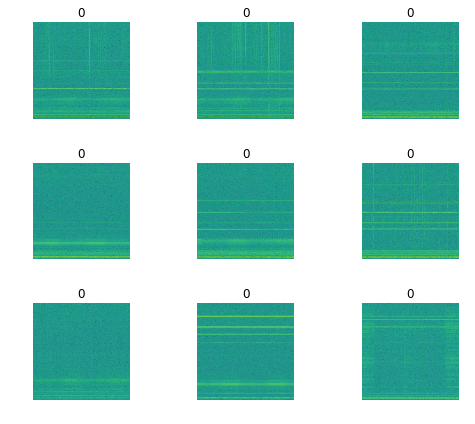

In [19]:
data.show_batch(rows=3, figsize=(7,6))

In [20]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

In [21]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [22]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.394546,0.148973,0.049943
2,0.180271,0.117676,0.037887
3,0.119622,0.113868,0.039610
4,0.083597,0.120224,0.044202
5,0.067082,0.115951,0.044202


In [23]:
learn.save(f'{MODEL_NAME}_stage-1')

## Results

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

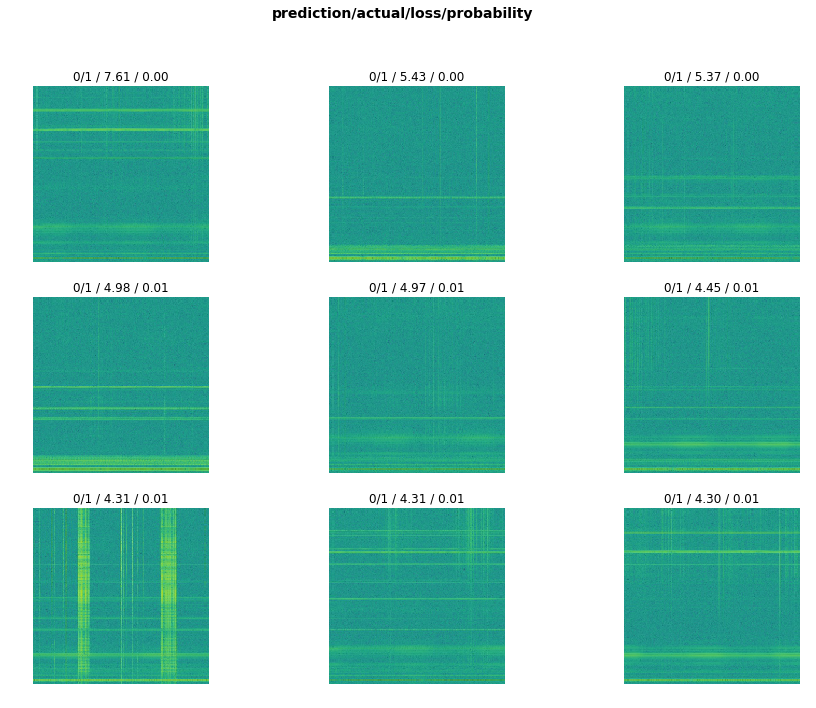

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

In [26]:
doc(interp.plot_top_losses)

plot_top_losses [source] plot_top_losses ( `k` , `largest` = `True` , `figsize` = `(12, 12)` ) 
 
 Show images in top_losses along with their prediction, actual, loss, and probability of predicted class. 
 Show in docs

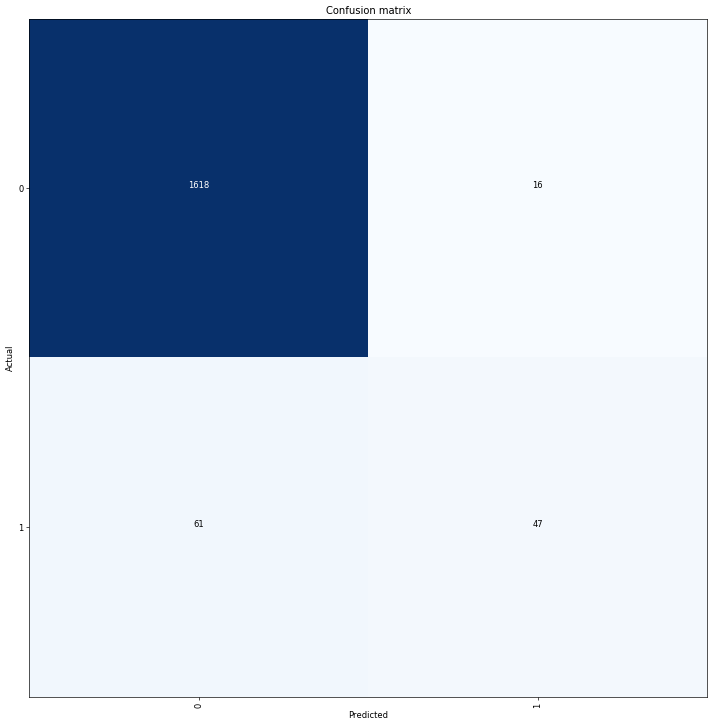

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [28]:
interp.most_confused(min_val=2)

[(1, 0, 61), (0, 1, 16)]

## Unfreezing, fine-tuning, and learning rates

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.119837,0.102497,0.046498


In [31]:
learn.load(f'{MODEL_NAME}_stage-1');

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


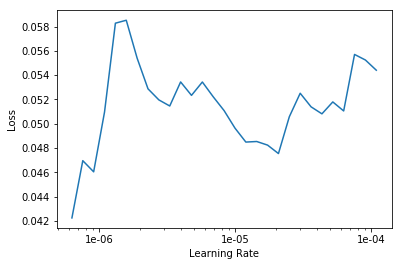

In [33]:
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,2e-5))

epoch,train_loss,valid_loss,error_rate
1,0.065552,0.115460,0.038462
2,0.050970,0.110981,0.039036
3,0.036028,0.109947,0.037887
4,0.028022,0.114705,0.037313
5,0.026272,0.109581,0.037887


In [35]:
learn.save(f'{MODEL_NAME}_stage-2_unfeeze')

### 1x1 prediction

In [36]:
#test_images = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [37]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [38]:
len(test_images)

20337

In [39]:
assert 20337 == len(test_images)

In [40]:
img = open_image(test_images[0])
type(img)

fastai.vision.image.Image

In [41]:
cat, val, probs=learn.predict(img)

In [42]:
cat.__str__()

'0'

In [43]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [44]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [45]:
df_sub=df_sub.reset_index()
df_sub.head()

,index,0
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [46]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [47]:
df_sub.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [48]:
len(df_sub)

20337

In [49]:
df_sub.to_csv(path/f'submissions/submission_{MODEL_NAME}_stage-2_unfeeze_{DATE}_{UID}.csv', index=False)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [50]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=4)
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=image_size, bs=bs//2).normalize(imagenet_stats)

In [51]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


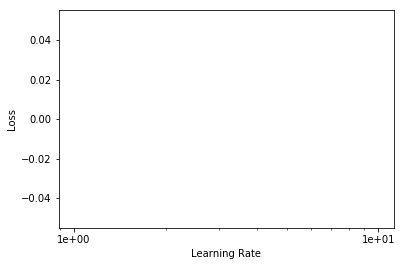

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(8, lrs)

epoch,train_loss,valid_loss,error_rate
1,0.176407,0.149633,0.051091
2,0.212478,0.143438,0.050517
3,0.145794,0.138950,0.053387
4,0.209239,0.138566,0.055109
5,0.156342,0.137877,0.051091
6,0.068360,0.134493,0.048794
7,0.133013,0.123394,0.045924
8,0.147986,0.122806,0.045924


In [54]:
#learn.fit_one_cycle(8)

In [55]:
learn.save(f'{MODEL_NAME}_stage-1-50')

In [56]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.092504,0.128454,0.047072
2,0.132064,0.122618,0.045924
3,0.086312,0.113742,0.042480


In [57]:
learn.save(f'{MODEL_NAME}_stage-2-50')

In [58]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.135575,0.132160,0.053387
2,0.080897,0.164708,0.053961
3,0.092432,0.114625,0.038462


In [59]:
learn.save(f'{MODEL_NAME}_stage-2-2-50')

In [60]:
#learn.load('baseline_stage-1-50');

In [61]:
interp = ClassificationInterpretation.from_learner(learn)

In [62]:
interp.most_confused(min_val=2)

[(1, 0, 40), (0, 1, 27)]

In [63]:
### Predict

In [64]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [65]:
df_sub_50_u=pd.DataFrame.from_dict(d, orient='index')

In [66]:
df_sub_50_u=df_sub_50_u.reset_index()


In [67]:
df_sub_50_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_50_u.head()

,signal_id,target
0,28678,0
1,24274,0
2,24224,0
3,12637,0
4,23610,0


In [68]:
df_sub_50_u.to_csv(path/f'submissions/submission_{MODEL_NAME}_resnet-50_unfeeze-2-2_{DATE}_{UID}.csv', index=False)